In [1]:
import os
import json

# Define paths
root_dir = "/content/drive/MyDrive/CODE/GITHUB/Agave_Vision/data/"
images_dir = os.path.join(root_dir, "images")
annotations_file = os.path.join(root_dir, "annotations.json")
filtered_annotations_file = os.path.join(root_dir, "filtered_annotations.json")

# Load original annotations
with open(annotations_file, "r") as file:
    content = json.load(file)

# Extract images and annotations
images = content["images"]
annotations = content["annotations"]

# Get the list of actual image files present in the dataset folder
existing_images = set(os.listdir(images_dir))  # Set for fast lookup

# Filter images that exist in the dataset folder
filtered_images = [img for img in images if img["file_name"] in existing_images]

# Get the valid image IDs after filtering
valid_image_ids = {img["id"] for img in filtered_images}

# Filter annotations to only keep those linked to valid images
filtered_annotations = [ann for ann in annotations if ann["image_id"] in valid_image_ids]

# Create a new annotation dictionary
filtered_content = {
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": content.get("categories", [])  # Retain category information
}

# Save the filtered annotations as a new file
with open(filtered_annotations_file, "w") as outfile:
    json.dump(filtered_content, outfile, indent=4)

print(f"✅ New annotation file created: {filtered_annotations_file}")
print(f"📌 Original images: {len(images)}, Available images: {len(filtered_images)}")
print(f"📌 Original annotations: {len(annotations)}, Filtered annotations: {len(filtered_annotations)}")


✅ New annotation file created: /content/drive/MyDrive/CODE/GITHUB/Agave_Vision/data/filtered_annotations.json
📌 Original images: 88, Available images: 88
📌 Original annotations: 4340, Filtered annotations: 4340


Sample Filenames from JSON:
Image ID: 1 -> Filename: WhatsApp Image 2024-10-22 at 09.10.24.jpeg
Image ID: 2 -> Filename: WhatsApp Image 2024-10-22 at 09.10.44.jpeg
Image ID: 3 -> Filename: WhatsApp Image 2024-10-22 at 09.10.45.jpeg
Image ID: 4 -> Filename: WhatsApp Image 2024-10-22 at 09.10.47.jpeg
Image ID: 5 -> Filename: WhatsApp Image 2024-10-22 at 09.10.51 (1).jpeg
Image ID: 6 -> Filename: WhatsApp Image 2024-10-22 at 09.10.51.jpeg


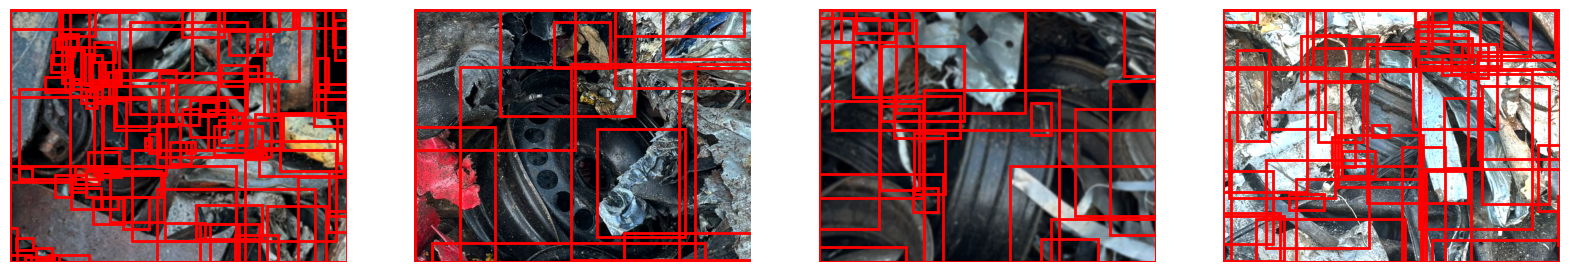

In [3]:
import os
import json
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import Counter
from torch.utils.data import Dataset, DataLoader

# Define paths
root_dir = "/content/drive/MyDrive/CODE/GITHUB/Agave_Vision/data/"
annotations_file = "filtered_annotations.json"
images_dir = os.path.join(root_dir, "images")  # Ensure correct image directory

# Load the dataset
with open(os.path.join(root_dir, annotations_file)) as file:
    content = json.load(file)

# Extract image and annotation details
images = content["images"]
annotations = content["annotations"]

# Create a mapping for image filenames using their IDs
image_id_to_filename = {img["id"]: img["file_name"] for img in images}

# Debugging: Print some filenames to verify
print("Sample Filenames from JSON:")
for i, (img_id, file_name) in enumerate(image_id_to_filename.items()):
    print(f"Image ID: {img_id} -> Filename: {file_name}")
    if i == 5:  # Print only a few samples
        break

# Define DETR augmentation pipeline
transform = A.Compose([
    #A.RandomResizedCrop(height=800, width=800, scale=(0.5, 1.0), ratio=(0.75, 1.33)),  # Random Crop + Resize
    A.HorizontalFlip(p=0.5),  # Random Horizontal Flip
    A.RandomBrightnessContrast(p=0.2),  # Adjust Brightness & Contrast
    A.HueSaturationValue(p=0.2),  # Adjust Hue, Saturation
    A.GaussianBlur(p=0.2),  # Apply Gaussian Blur
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize as per ImageNet standards
    ToTensorV2(),  # Convert to Tensor
], bbox_params=A.BboxParams(format="coco", label_fields=["category_ids"]))


class DETRDataset(Dataset):
    def __init__(self, root_dir, images, annotations, transform=None):
        self.root_dir = root_dir
        self.images = images
        self.annotations = annotations
        self.transform = transform
        self.image_id_to_annotations = self.group_annotations_by_image()

    def group_annotations_by_image(self):
        """
        Groups all annotations by image ID.
        """
        img_annots = {img["id"]: [] for img in self.images}
        for annot in self.annotations:
            img_annots[annot["image_id"]].append(annot)
        return img_annots

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Loads an image and applies augmentation.
        """
        img_info = self.images[idx]
        img_id = img_info["id"]

        # Ensure correct file name mapping
        img_filename = image_id_to_filename.get(img_id, None)
        if img_filename is None:
            raise ValueError(f"Image ID {img_id} has no associated file name!")

        img_path = os.path.join(self.root_dir, "images", img_filename)

        # Read image
        if not os.path.exists(img_path):
            print(f"Warning: Image file '{img_path}' not found! Skipping this sample.")
            return None  # Skip missing images

        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Get bounding boxes & categories
        bboxes = []
        category_ids = []
        for annot in self.image_id_to_annotations[img_id]:
            x, y, w, h = annot["bbox"]
            bboxes.append([x, y, w, h])
            category_ids.append(annot["category_id"])

        # Apply augmentation
        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_ids)
            image = transformed["image"]
            bboxes = transformed["bboxes"]
            category_ids = transformed["category_ids"]

        return image, bboxes, category_ids


# Create dataset
dataset = DETRDataset(root_dir, images, annotations, transform=transform)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize some augmented images
def visualize_augmentations(dataset, num_samples=4):
    """
    Plots augmented images with their bounding boxes.
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i in range(num_samples):
        sample = dataset[i]
        if sample is None:
            continue  # Skip missing images

        image, bboxes, category_ids = sample
        img_np = image.permute(1, 2, 0).numpy()  # Convert to numpy for visualization

        # Denormalize Image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = (img_np * std) + mean  # Reverse normalization
        img_np = np.clip(img_np, 0, 1)

        # Plot
        axes[i].imshow(img_np)
        for bbox in bboxes:
            x, y, w, h = bbox
            rect = plt.Rectangle((x, y), w, h, fill=False, color="red", linewidth=2)
            axes[i].add_patch(rect)
        axes[i].axis("off")

    plt.show()

# Show augmented samples
visualize_augmentations(dataset)
